# Classification for Bars-Stripes dataset

Follow tutorial from $\rightarrow$ https://pennylane.ai/qml/demos/tutorial_tn_circuits/
- check on images 4x4, 8x8, 16x16
- on MPS - acc = 50%
- check on TTNs - **TODO**

In [1]:
import pennylane as qml
import matplotlib.pyplot as plt
import numpy as np
import jax
import jax.numpy as jnp
from jax.nn.initializers import *
import optax

from tn4ml.embeddings import *
from tn4ml.util import *
from tn4ml.models.model import *
from tn4ml.models.smpo import *
from tn4ml.initializers import *
from tn4ml.loss import *

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
/Users/emapuljak/miniforge3/envs/workspace/lib/python3.10/site-packages/cotengra/hyperoptimizers/hyper.py:34: UserWarning: Couldn't import `kahypar` - skipping from default hyper optimizer and using basic `labels` method instead.
  warnings.warn(


In [2]:
def generate_bars_and_stripes(n_samples, height, width, noise_std):
    """Data generation procedure for 'bars and stripes'.

    Args:
        n_samples (int): number of data samples to produce
        height (int): number of pixels for image height
        width (int): number of pixels for image width
        noise_std (float): standard deviation of Gaussian noise added to the pixels
    """
    X = np.ones([n_samples, 1, height, width]) * -1
    y = []

    for i in range(len(X)):
        if np.random.rand() > 0.5:
            rows = np.where(np.random.rand(width) > 0.5)[0]
            X[i, 0, rows, :] = 1.0
            y.append([1, 0])
        else:
            columns = np.where(np.random.rand(height) > 0.5)[0]
            X[i, 0, :, columns] = 1.0
            y.append([0, 1])
        X[i, 0] = X[i, 0] + np.random.normal(0, noise_std, size=X[i, 0].shape)

    return X, np.array(y)

In [3]:
height = 4
width = 4
noise_std = 0.5

In [4]:
train_images, train_labels = generate_bars_and_stripes(1000, height, width, 0.5)
test_images, test_labels = generate_bars_and_stripes(200, height, width, 0.5)

In [5]:
train_labels = train_labels.astype(int)
test_labels = test_labels.astype(int)

In [6]:
n_classes=2

In [7]:
train_images = np.squeeze(train_images)
test_images = np.squeeze(test_images)

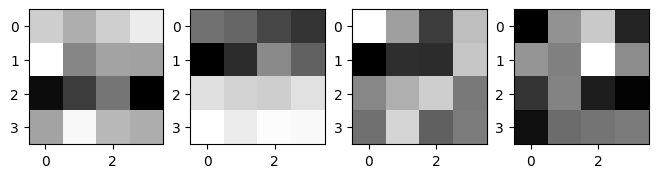

In [8]:
fig, axes = plt.subplots(ncols=4, figsize=(8,8))

axes[0].imshow(np.reshape(-train_images[0], (4,4)), cmap='gray')
axes[1].imshow(np.reshape(-train_images[4], (4,4)), cmap='gray')
axes[2].imshow(np.reshape(-train_images[6], (4,4)), cmap='gray')
axes[3].imshow(np.reshape(-train_images[3], (4,4)), cmap='gray')

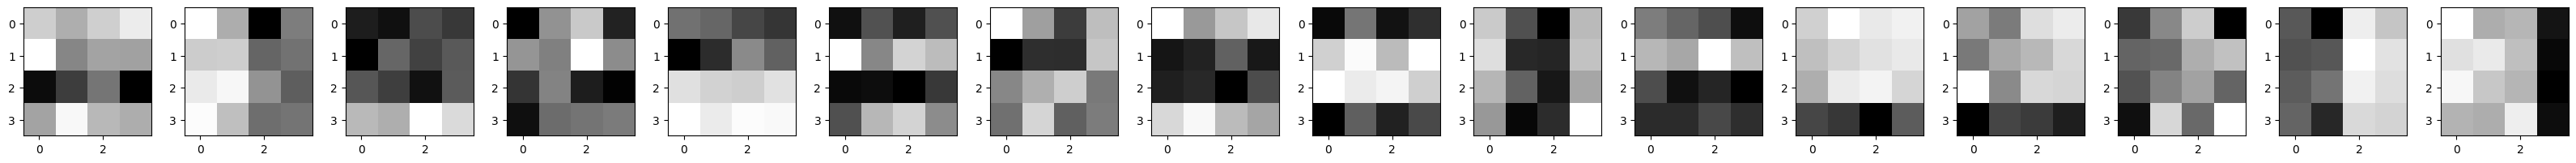

In [9]:
def visualize_patterns(dataset, num_patterns=10):
    fig, axes = plt.subplots(1, num_patterns, figsize=(num_patterns * 2, 2))
    for i, ax in enumerate(axes):
        pattern = dataset[i]
        ax.imshow(pattern, cmap='binary')
    plt.tight_layout()
    plt.show()
visualize_patterns(train_images, 16)


In [10]:
train_size = train_images.shape[0]
val_perc = 0.2

In [11]:
# take val_size samples from normal class for validation (X% of training data)
val_size = int(val_perc*train_size)
train_size = int(train_size - val_size)

In [12]:
indices = list(range(len(train_images)))
np.random.shuffle(indices)

train_indices = indices[:train_size]
val_indices = indices[train_size : train_size+val_size]

# train data and validation inputs
train_inputs = np.take(train_images, train_indices, axis=0)
val_inputs = np.take(train_images, val_indices, axis=0)


# train data and validation labels
train_targets = np.take(train_labels, train_indices, axis=0)
val_targets = np.take(train_labels, val_indices, axis=0)

**Define TN model**

In [13]:
# model parameters
L = 16
initializer = jax.nn.initializers.normal(0.5, dtype=jnp.float64)
key = jax.random.key(42)
shape_method = 'noteven'
bond_dim = 4
phys_dim = (2, n_classes)
spacing = L

In [14]:
model = SMPO_initialize(L=L,
                        initializer=initializer,
                        key=key,
                        shape_method=shape_method,
                        spacing=spacing,
                        bond_dim=bond_dim,
                        phys_dim=phys_dim,
                        cyclic=False)

In [15]:
model

SpacedMatrixProductOperator(tensors=16, indices=32, L=16, max_bond=4)

In [16]:
def cross_entropy(*args, **kwargs):
    return loss_wrapper_optax(optax.softmax_cross_entropy)(*args, **kwargs)[0]

In [17]:
# training parameters
optimizer = optax.adam
strategy = 'global'
loss = cross_entropy
train_type = 1
#embedding = basis_quantum_encoding(basis={0: np.array([1, 0]), 1: np.array([0, 1])})
embedding = trigonometric()
learning_rate = 1e-3

# Exponential decay of the learning rate.
scheduler = optax.exponential_decay(
    init_value=0.0001,
    transition_steps=1000,
    decay_rate=0.99)

# Combining gradient transforms using `optax.chain`.
gradient_transforms = [
    optax.clip_by_global_norm(1.0),  # Clip by the gradient by the global norm.
    optax.scale_by_adam(),  # Use the updates from adam.
    optax.scale_by_schedule(scheduler),  # Use the learning rate from the scheduler.
    # Scale updates by -1 since optax.apply_updates is additive and we want to descend on the loss.
    optax.scale(-1.0)
]

In [18]:
model.configure(optimizer=optimizer, strategy=strategy, loss=loss, train_type=train_type, learning_rate=learning_rate)

In [19]:
epochs = 300
batch_size = 32

In [20]:
# early stopping from flax
from flax.training.early_stopping import EarlyStopping

earlystop = EarlyStopping(min_delta=0, patience=5)

In [21]:
history = model.train(train_inputs.reshape(train_inputs.shape[0], height*width),
                    targets = train_targets,
                    val_inputs=val_inputs.reshape(val_inputs.shape[0], height*width),
                    val_targets=val_targets,
                    epochs = epochs,
                    batch_size = batch_size,
                    embedding = embedding,
                    normalize = True,
                    cache=True,
                    dtype = jnp.float64)

epoch: 100%|██████████| 300/300 [02:32<00:00,  1.97it/s, loss=0.6344693026188025, val_loss=0.7747172157966723]


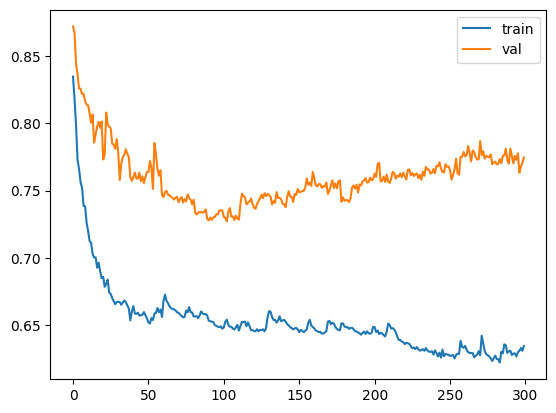

In [22]:
plt.figure()
plt.plot(range(len(history['loss'])), history['loss'], label='train')
plt.plot(range(len(history['val_loss'])), history['val_loss'], label='val')
plt.legend()
plt.show()


**Evaluate**

In [23]:
from tn4ml.models.model import _batch_iterator

In [25]:
batch_size = 10
correct_predictions = 0; total_loss = 0

for batch_data in _batch_iterator(test_images.reshape(test_images.shape[0], 16), test_labels, batch_size=batch_size):
    x, y = batch_data
    x = jnp.array(x, dtype=jnp.float64)
    y = jnp.array(y)

    y_pred = jnp.squeeze(jnp.array(jax.vmap(model.predict, in_axes=(0, None, None))(x, embedding, False)[0]))
    print(y_pred)
    predicted = jnp.argmax(y_pred, axis=-1)
    true = jnp.argmax(y, axis=-1)

    correct_predictions += jnp.sum(predicted == true).item() / batch_size

accuracy = correct_predictions / (len(test_images)//batch_size)
print(f"Accuracy: {accuracy}")

[[ 1.16009805e-03  7.91098255e-04]
 [-2.57028956e-03 -2.70683206e-03]
 [ 1.00054256e-04  4.78574601e-05]
 [-1.50681319e-04 -8.40423952e-05]
 [-1.26200183e-03 -5.84477422e-04]
 [-6.51928356e-03 -8.53623838e-03]
 [-1.28240092e-02 -1.15055430e-02]
 [-1.88100383e-04 -3.39844154e-04]
 [-6.00185323e-06  5.07520779e-05]
 [-5.75047386e-03 -1.08485571e-02]]
[[-2.66700924e-03 -3.65199412e-03]
 [ 4.97761262e-04 -4.91942181e-06]
 [-6.75016080e-03 -5.02690365e-03]
 [ 4.08968092e-04  1.84176448e-03]
 [-1.72908966e-03 -1.76426168e-03]
 [-6.41010730e-04 -1.26187844e-04]
 [-7.04497188e-04 -1.53250988e-04]
 [-2.47333248e-02 -2.70750072e-02]
 [-3.98530931e-03 -8.65745736e-03]
 [ 1.55932296e-03  7.45546151e-03]]
[[ 7.66135619e-03  1.21668651e-02]
 [-1.75029783e-05  5.10317129e-06]
 [ 9.62582630e-04  1.34637245e-03]
 [-1.70638798e-03 -2.04201954e-03]
 [-2.65793223e-05  3.97285156e-06]
 [-3.68568292e-04 -3.93541928e-04]
 [ 2.81379224e-04  2.57386543e-04]
 [-2.16385683e-03 -2.70915779e-03]
 [-6.83685949e-03 